![churn](..\figures\churn.png)

#  Part 1: Customer Churn Exploratory Analysis

### Goals for Part 1:
- Understand the dataset
- Test if our label (churn) is balanced or unbalanced
- User visualization to see if there are differences within certain groups relating to churn
- Encode categorical variables
- Determine which features have a strong correlation to churn

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
df = pd.read_csv('../data/Telco-Customer-Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Many features appear to be categorical / strings

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null object
dtypes: float64(2), int64(2), ob

### Of the numerical features, 'Senior Citizen' appears to be boolean, 0 or 1

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


### Check for NULL values

In [6]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Check cardinality of the features in the dataset
- A high number of unique values means the feature is likely continuous
- A low number of unique values means the featur is likely categorical

In [7]:
df.nunique()

customerID          7032
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

### Check for how balanced the label is
- This dataset is relatively balanced
- Imbalanced labels will lead to accuracy issues for machine learning predictions


### To balance out the data set:
- `from sklearn.utils import resample`

**Upsample minority class**
- Separate observations from each class into different DataFrames
- Resample *with replacement*, setting the number of samples to match that of the majority class
- Combine the up-sampled minority class DataFrame with the original majority class DataFrame

**Downsample majority class**
- Separate observations from each class into different DataFrames
- Resample *without replacement*, setting the number of samples to match that of the minority class
- Combine the down-sampled majority class DataFrame with the original minority class DataFrame

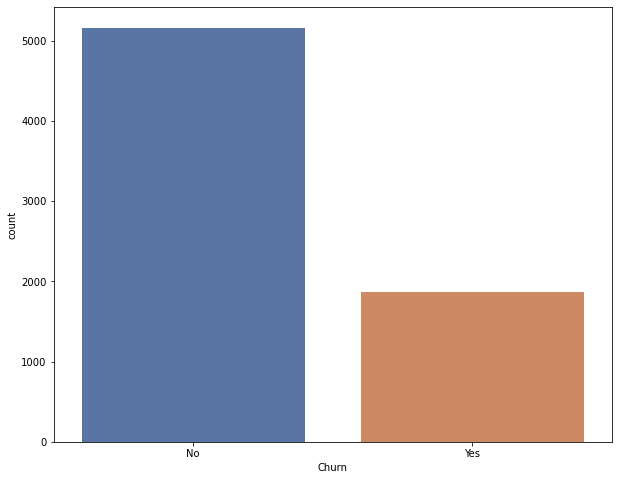

In [65]:
sns.set_palette("deep")
fig, ax = plt.subplots(figsize=(10,8))
sns.countplot(data=df, x='Churn', ax=ax);

In [50]:
df['Churn'].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [49]:
df['Churn'].value_counts(normalize=True).mul(100)

No     73.421502
Yes    26.578498
Name: Churn, dtype: float64

### Upsample minority class

In [63]:
min_df = df.loc[df['Churn'] == 'Yes']
maj_df = df.loc[df['Churn'] == 'No']

df_minority_upsampled = resample(min_df, 
                                 replace=True,     # sample with replacement
                                 n_samples=5163,    # to match majority class
                                 random_state=101) # reproducible results

df_upsampled = pd.concat([maj_df, df_minority_upsampled])

df_upsampled['Churn'].value_counts()

Yes    5163
No     5163
Name: Churn, dtype: int64

### Churn Observations
- Customers who have left have lower total charges than customers who have stayed
- Month to month customers have the lowest total charges
    - Total charges are closer for month-to-month customers, regardless of churn status
    - This makes sense, as people who are on month-to-month plans are not committed and are probably looking for flexability
- Looking at the 1 and 2 year contracts, customers who left have higher total charges than those that stayed
    - Higher costs potentially drove away customers
    - Possible solution to keep customers would be fee rebates or cost reductions tied to contract milestones

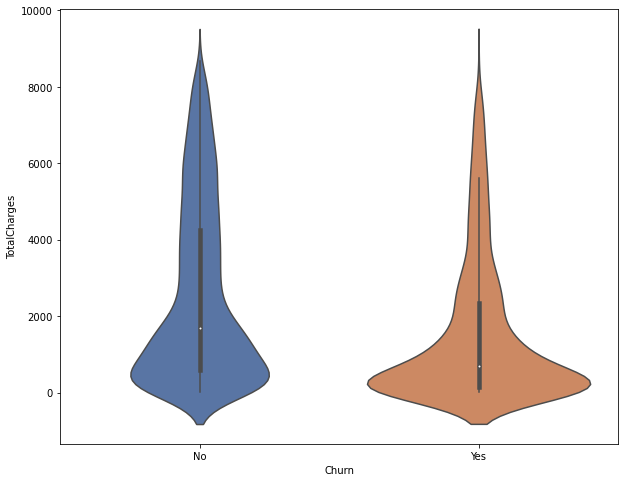

In [66]:
fig, ax = plt.subplots(figsize=(10,8))
sns.violinplot(data=df, ax=ax, x='Churn', y='TotalCharges');

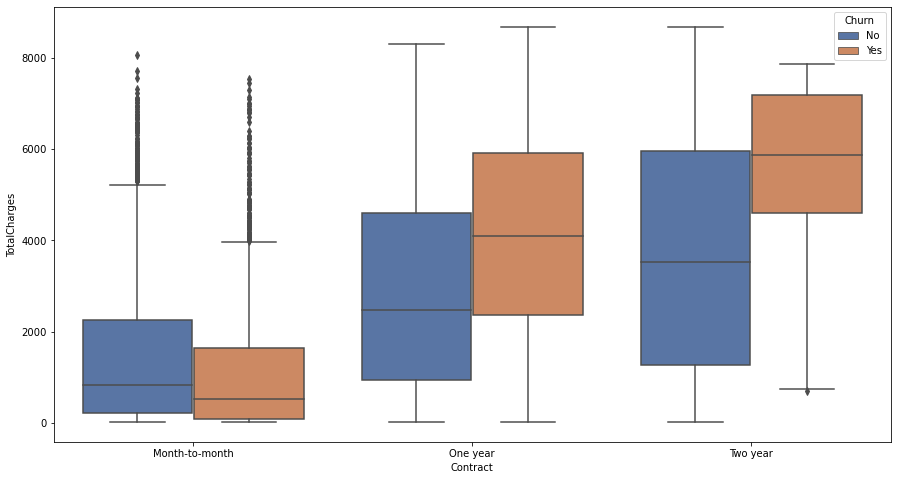

In [67]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=df, ax=ax, x='Contract', y='TotalCharges', hue='Churn');

### Correlation analysis
- Convert categorical features into numerical format via one-hot encoding 
- Drop columns that have high cardinality
- Calculate the correlation coefficient

In [11]:
df_subset = df.loc[:,df.nunique()<10]
corr = pd.get_dummies(df_subset).corr()
corr.head()

,SeniorCitizen,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
SeniorCitizen,1.000000,0.001819,-0.001819,-0.016957,0.016957,0.210550,-0.210550,-0.008392,0.008392,-0.136377,...,-0.046491,-0.116205,-0.156258,0.156258,-0.016235,-0.024359,0.171322,-0.152987,-0.150541,0.150541
gender_Female,0.001819,1.000000,-1.000000,-0.001379,0.001379,0.010349,-0.010349,-0.007515,0.007515,-0.004335,...,-0.007755,0.003603,-0.011902,0.011902,0.015973,-0.001632,-0.000844,-0.013199,-0.008545,0.008545
gender_Male,-0.001819,-1.000000,1.000000,0.001379,-0.001379,-0.010349,0.010349,0.007515,-0.007515,0.004335,...,0.007755,-0.003603,0.011902,-0.011902,-0.015973,0.001632,0.000844,0.013199,0.008545,-0.008545
Partner_No,-0.016957,-0.001379,0.001379,1.000000,-1.000000,0.452269,-0.452269,0.018397,-0.018397,0.130028,...,-0.083067,-0.247334,-0.013957,0.013957,-0.111406,-0.082327,0.083207,0.096948,-0.149982,0.149982
Partner_Yes,0.016957,0.001379,-0.001379,-1.000000,1.000000,-0.452269,0.452269,-0.018397,0.018397,-0.130028,...,0.083067,0.247334,0.013957,-0.013957,0.111406,0.082327,-0.083207,-0.096948,0.149982,-0.149982


In [12]:
corr_sort = corr['Churn_Yes'].sort_values().iloc[1:-1]
corr_sort

Contract_Two year                         -0.301552
StreamingMovies_No internet service       -0.227578
StreamingTV_No internet service           -0.227578
TechSupport_No internet service           -0.227578
DeviceProtection_No internet service      -0.227578
OnlineBackup_No internet service          -0.227578
OnlineSecurity_No internet service        -0.227578
InternetService_No                        -0.227578
PaperlessBilling_No                       -0.191454
Contract_One year                         -0.178225
OnlineSecurity_Yes                        -0.171270
TechSupport_Yes                           -0.164716
Dependents_Yes                            -0.163128
Partner_Yes                               -0.149982
PaymentMethod_Credit card (automatic)     -0.134687
InternetService_DSL                       -0.124141
PaymentMethod_Bank transfer (automatic)   -0.118136
PaymentMethod_Mailed check                -0.090773
OnlineBackup_Yes                          -0.082307
DeviceProtec

### Visualize the correlation coeeficients
- Ordered barplot
- Heatmap

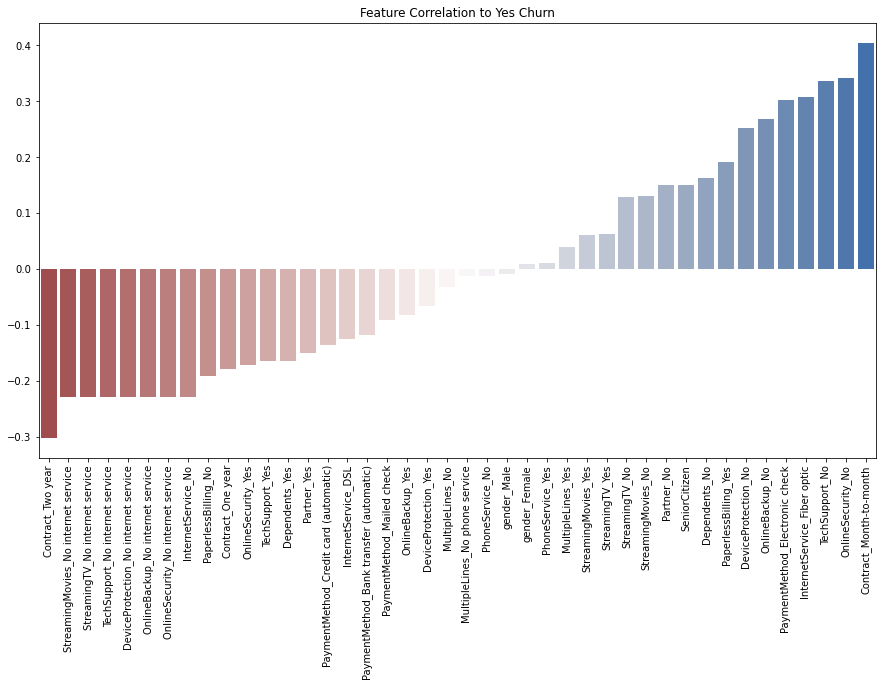

In [70]:
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(ax=ax, x=corr_sort.index, y=corr_sort.values, palette='vlag_r')
ax.set_title('Feature Correlation to Yes Churn')
ax.set_xticklabels(corr_sort.index, rotation=90);

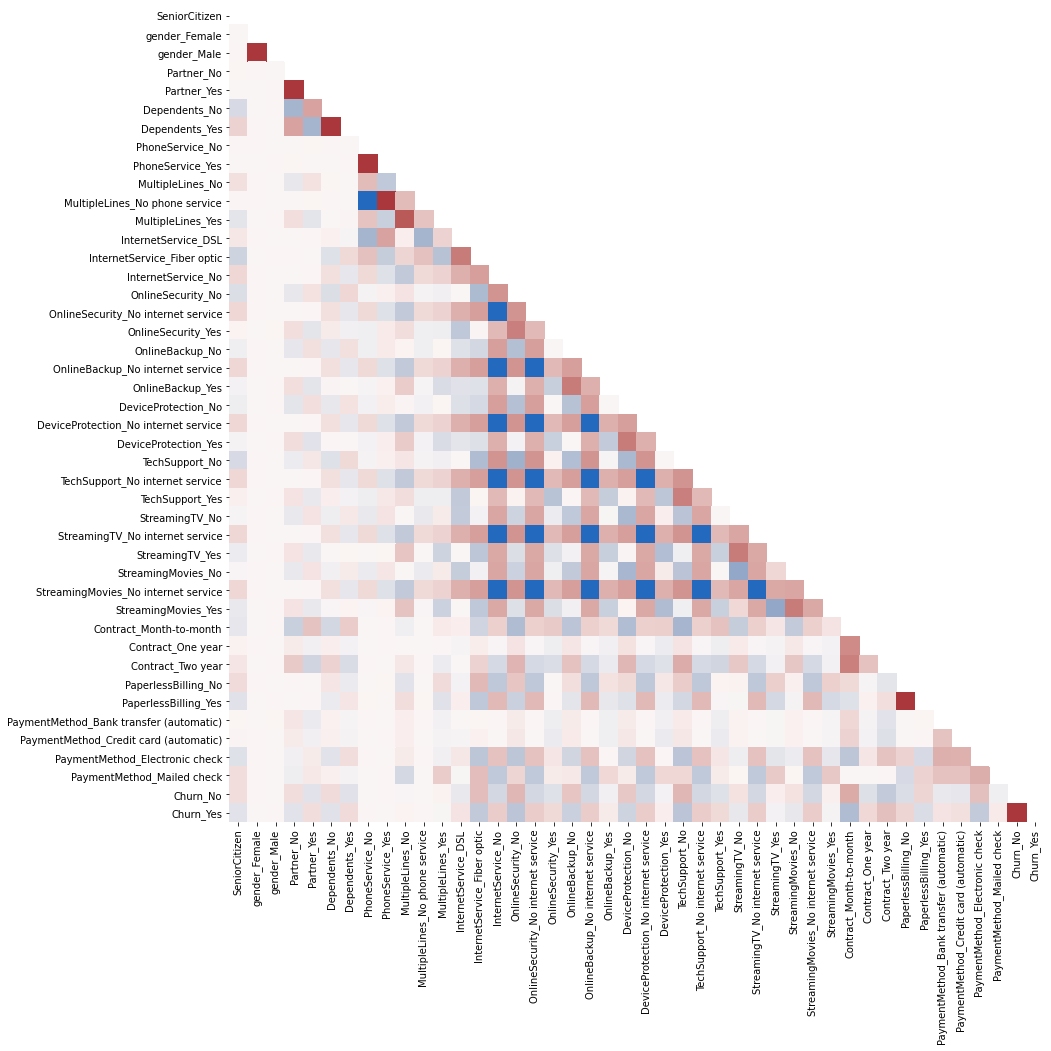

In [44]:
corr2 = pd.get_dummies(df_subset, drop_first=False).corr()
fig, ax = plt.subplots(figsize=(15,15))
mask = np.triu(np.ones_like(corr2, dtype=bool))
sns.heatmap(corr2, mask=mask, center=0, annot=False, fmt='.2f', square=True, cmap='vlag_r', cbar=False, ax=ax);

#  Part 2: Customer Churn Cohort Analysis

### Goals for Part 2:
- Take a deeper dive into the data
- Segement the customer base for cohort analysis
- Explore the relationship between monthly charges and total charges